In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import _linear
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle

from plot_module import text_plot
from plot_module import structure_vocabulary_plots
from plot_module import ComparePlots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import id2char
from model_module import char2id
from model_module import BatchGenerator
from model_module import characters
from model_module import batches2string
from model_module import logprob
from model_module import sample_distribution
from model_module import MODEL

In [3]:
if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'w')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'r')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)    

number of not one byte characters:  0
min order index:  9
max order index:  255
total number of characters:  196


In [34]:
#different
offset = 30000
valid_size = 30000
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99320000 [http://dwardmac.pitzer.edu/Anarchist_Archives/bakunin/godandsta
30000 n in the February 1934 riots, anarchists divided over a 'united 


In [5]:
#different
interval = 190
num_inserts = 20
offset = 20000
valid_size = 10
valid_text = text[offset:offset+valid_size]
position = offset+valid_size
inserts_counter = 0
train_text = u''
while (position < len(text)) and inserts_counter < num_inserts:
    train_text += valid_text
    train_text += text[position:position+interval]
    position += interval
    inserts_counter += 1
train_text += text[position:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99360190 ture in Mutual Aid: A Factor of Evolution (1897). Subsequent ana
10 ture in Mu


In [6]:
#different
offset_1 = 0
offset_2 = 4100
valid_size_1 = 4000
valid_size_2 = 4000
valid_text_1 = text[offset_1:offset_1+valid_size_1]
valid_text_2 = text[offset_2:offset_2+valid_size_2]
train_text = text[offset_2+valid_size_2:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size_1, valid_text_1[:64])
print(valid_size_2, valid_text_2[:64])
print(valid_text_1)
print('\n\n\n')
print(valid_text_2)

99371900 , Zeno &quot;repudiated the omnipotence of the state, its interv
4000 <mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmln
4000 reserve">{{Anarchism}}
'''Anarchism''' originated as a term of a
<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd" version="0.3" xml:lang="en">
  <siteinfo>
    <sitename>Wikipedia</sitename>
    <base>http://en.wikipedia.org/wiki/Main_Page</base>
    <generator>MediaWiki 1.6alpha</generator>
    <case>first-letter</case>
      <namespaces>
      <namespace key="-2">Media</namespace>
      <namespace key="-1">Special</namespace>
      <namespace key="0" />
      <namespace key="1">Talk</namespace>
      <namespace key="2">User</namespace>
      <namespace key="3">User talk</namespace>
      <namespace key="4">Wikipedia</namespace>
      <namespace key="5">Wikipedia talk</n

In [7]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)


string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]
print("Vocabulary: ", string_vocabulary)
print("char2id(u'a') = %s,  char2id(u'z') = %s,  char2id(u' ') = %s" % (char2id(u'a', characters_positions_in_vocabulary),
                                                                        char2id(u'z', characters_positions_in_vocabulary),
                                                                        char2id(u' ', characters_positions_in_vocabulary)))
print("id2char(78) = %s,  id2char(156) = %s,  id2char(140) = %s" % (id2char(78,
                                                                            vocabulary),
                                                                    id2char(156,
                                                                            vocabulary),
                                                                    id2char(140,
                                                                            vocabulary)))


Vocabulary:  	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ
char2id(u'a') = 67,  char2id(u'z') = 92,  char2id(u' ') = 2
id2char(78) = l,  id2char(156) = Ø,  id2char(140) = È


In [8]:
batch_size_test=64
num_unrollings_test=10

train_batches_test = BatchGenerator(train_text,
                                    batch_size_test,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    num_unrollings_test)
valid_batches_test = BatchGenerator(valid_text_1,
                                    1,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    1)

print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))

[u', Zeno &quo', u'act science', u'] systems. ', u"* ''Women E", u'nis. It ori', u'ilanthus al', u'ave diminis', u't;Advance A', u'orded in ce', u' late [[179', u'. A strong ', u'bodia]] led', u'f the Hill]', u']] | above=', u"t rather ''", u"d 'Babe Rut", u'[Chicago Wh', u'overed to b', u'when he spr', u' search].\n*', u'erminology=', u'ile.\n\n====1', u'ife and car', u'509</id>\n  ', u' featured i', u'other marin', u'ere has bee', u' be copied ', u' subdivisio', u'eased drawi', u'include:\n\n[', u'for the thi', u'age do not ', u'ion>\n      ', u'(book)|Drag', u': ([[1921]]', u'ndia in ord', u'how can we ', u'</timestamp', u's and also ', u'n ==\nThe Es', u'nredlist.or', u' fully or p', u'ma was revi', u'ometimes &l', u'when there ', u' and [[pena', u'arkets (see', u'uage with t', u'the [[Ameri', u'lable power', u'ername>\n   ', u'phen]]s in ', u'ws and the ', u' culture ha', u'uardians of', u'llaboration', u'ot;Lords of', u' Howard, 3r', u'ersonnel ca', u' drafts [[l', u'edarville, '

In [9]:

class ACT_RNN(MODEL):
    
    def rnn_cell(self, inp, state):
        X = tf.concat(1, [inp,
                          state])
        output = tf.tanh(tf.matmul(X, self.Matrix) + self.Bias)
        return output
    
    def add_flag_to_input(self, X, idx):
        flags = list()
        one_flag = [0.]*self._depth
        one_flag[idx] = 1.
        flag = tf.pack([tf.constant(one_flag)] * X.get_shape().as_list()[0])
        return tf.concat(1, [X, flag])
    
    def compute_halting_units(self, intermediate_states):
        states_concat = tf.concat(0, intermediate_states)
        halting_units = tf.sigmoid(tf.matmul(states_concat, self.Halting_Matrix) + self.Halting_Bias)
        return tf.split(0, len(intermediate_states), halting_units)
    
    def compute_probabilities(self, halting_units):
        b_size = halting_units[0].get_shape().as_list()[0]
        agregate = tf.zeros([b_size, 1])
        completed = tf.zeros([b_size, 1])
        ones = tf.ones([b_size, 1])
        minus_ones = - ones
        probabilities = list()
        prob_loss = 0
        for idx, halting_unit in enumerate(halting_units):
            if idx == self._depth - 1:
                completed_flags = tf.to_float(tf.greater(agregate, -0.5))
            else:
                completed_flags = tf.to_float(tf.greater(agregate + halting_unit, self._threshold))
            completed += completed_flags
            probabilities.append((ones - completed) * halting_unit + completed_flags * (ones - agregate))
            prob_loss += tf.reduce_sum(completed_flags * (ones - agregate))
            agregate = minus_ones * completed + (ones - completed) * (agregate + halting_unit)
        return probabilities, prob_loss
            
    def compute_number_of_iterations(self, probabilities):
        probs = tf.concat(1, probabilities)
        looped = tf.greater(probs, 0)
        looped = tf.to_int32(looped)
        return tf.reduce_sum(looped, reduction_indices=[1])
               
    
    def iteration(self, inp, state):
        intermediate_states = list()
        for idx in range(self._depth):
            state = self.rnn_cell(self.add_flag_to_input(inp, idx), state)
            intermediate_states.append(state)
        halting_units = self.compute_halting_units(intermediate_states)
        probabilities, prob_loss = self.compute_probabilities(halting_units)
        number_of_iterations = self.compute_number_of_iterations(probabilities)
        new_state = 0
        for inter_state, probability in zip(intermediate_states, probabilities):
            new_state +=  inter_state * probability
        return new_state, [new_state], prob_loss, number_of_iterations, probabilities, halting_units

    
    def __init__(self,
                 batch_size,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 num_nodes,
                 depth,
                 indent,
                 time_penalty,
                 train_text,
                 valid_text,
                 mean=0.,
                 stddev='default',
                 shift=0.,
                 init_learning_rate=1.):
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        
        self._num_unrollings = num_unrollings

        self._num_layers = 1
        self._num_nodes = num_nodes
        self._depth = depth
        self._indent = indent
        self._time_penalty = time_penalty
        self._threshold = 1. - indent
        self._train_text = train_text
        self._valid_text = valid_text
        if isinstance(self._valid_text, dict):
            keys = self._valid_text.keys()
            self._valid_size = dict([zipped for zipped in zip(keys, [len(self._valid_text[key]) for key in keys])])
        else:
            self._valid_size = len(valid_text)
        
        
        self._mean = mean
        
        self._shift = shift
        
        self._stddev = list()
        if stddev == 'default':
            self._stddev = 1.
        else:
            self._stddev = stddev

        self._init_learning_rate = init_learning_rate
  
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "num_layers": 2,
                         "num_nodes": 3,
                         "depth": 4,
                         "indent": 5,
                         "time_penalty": 6,
                         "half_life": 7,
                         "decay": 8,
                         "num_steps": 9,
                         "averaging_number": 10,
                         "init_mean": 11,
                         "init_stddev": 12,
                         "init_shift": 13,
                         "init_learning_rate": 14,                         
                         "type": 15}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default(): 
            with self._graph.device('/gpu:0'): 
                self.Matrix = tf.Variable(tf.truncated_normal([self._vocabulary_size + self._num_nodes[0] + self._depth,
                                                                      self._num_nodes[0]],
                                                                     mean=self._mean, stddev=self._stddev / (self._vocabulary_size + self._num_nodes[0] + self._depth)**0.5))
                self.Bias = tf.Variable(tf.zeros([self._num_nodes[0]]))
                
                self.Halting_Matrix = tf.Variable(tf.truncated_normal([self._num_nodes[0],
                                                                      1],
                                                                     mean=self._mean, stddev=self._stddev / self._num_nodes[0]**0.5))
                
                self.Halting_Bias = tf.Variable([[self._shift]])
                # classifier 
                weights = tf.Variable(tf.truncated_normal([self._num_nodes[-1], self._vocabulary_size], stddev = self._stddev / self._num_nodes[-1]**0.5))
                bias = tf.Variable(tf.zeros([self._vocabulary_size]))
                
                """PLACEHOLDERS train data"""
                self._train_data = list()
                for _ in range(self._num_unrollings + 1):
                    self._train_data.append(
                        tf.placeholder(tf.float32, shape=[self._batch_size, self._vocabulary_size]))
                    
                    
                train_inputs = self._train_data[: self._num_unrollings]
                train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                # Unrolled LSTM loop.
                
                """global step"""
                self._global_step = tf.Variable(0, trainable=False)

                saved_state = list()
                for i in range(self._num_layers):
                    saved_state.append(tf.Variable(tf.zeros([self._batch_size, self._num_nodes[i]]), trainable=False))

                outputs = list()
                state = saved_state
                self.number_of_iterations = list()
                first_inputs = list()
                first_outputs = list()
                for i in train_inputs:
                    output, state, prob_loss, number_of_iterations, _, _ = self.iteration(i, state[0])
                    self.number_of_iterations.append(tf.unpack(number_of_iterations)[0])
                    outputs.append(output)
                    first_inputs.append(tf.split(0, self._batch_size, i)[0])
                    first_outputs.append(tf.split(0, self._batch_size, output)[0])
                self.first_inputs = tf.concat(0, first_inputs)
                self.first_outputs = tf.nn.softmax(tf.nn.xw_plus_b(tf.concat(0, first_outputs), weights, bias))
                self.number_of_iterations = tf.pack(self.number_of_iterations)    

                save_list = list()
                for i in range(self._num_layers):
                    save_list.append(saved_state[i].assign(state[i]))
                
                """skip operation"""
                self._skip_operation = tf.group(*save_list)

                with tf.control_dependencies(save_list):
                        # Classifier.
                    logits = tf.nn.xw_plus_b(tf.concat(0, outputs), weights, bias)
                    """loss"""
                    self._loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                        logits, tf.concat(0, train_labels))) + self._time_penalty * prob_loss

                # Optimizer.
                
                """PLACEHOLDERS half life and decay"""
                self._half_life = tf.placeholder(tf.int32)
                self._decay = tf.placeholder(tf.float32)
                """learning rate"""
                self._learning_rate = tf.train.exponential_decay(self._init_learning_rate,
                                                                 self._global_step,
                                                                 self._half_life,
                                                                 self._decay,
                                                                 staircase=True)
                optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)
                gradients, v = zip(*optimizer.compute_gradients(self._loss))
                gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
                """optimizer"""
                self._optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)
                """train prediction"""
                self._train_prediction = tf.nn.softmax(logits)


                # Sampling and validation eval: batch 1, no unrolling.
                # Sampling and validation eval: batch 1, no unrolling.
                saved_sample_state = list()
                for i in range(self._num_layers):
                    saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[i]]), trainable=False)) 
                """PLACEHOLDER sample input"""
                self._sample_input = tf.placeholder(tf.float32, shape=[1, self._vocabulary_size])

                reset_list = list()
                for i in range(self._num_layers):
                    reset_list.append(saved_sample_state[i].assign(tf.zeros([1, self._num_nodes[i]])))

                """reset sample state"""
                self._reset_sample_state = tf.group(*reset_list)

                sample_output, sample_state, _, self.num_iter, self.probs, hu = self.iteration(self._sample_input, saved_sample_state[0])

                self.halting_units = tf.concat(1, hu)
                sample_save_list = list()
                for i in range(self._num_layers):
                    sample_save_list.append(saved_sample_state[i].assign(sample_state[i]))

                with tf.control_dependencies(sample_save_list):
                    """sample prediction"""
                    self._sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, weights, bias)) 
                
                
                """saver"""
                self.saver = tf.train.Saver(max_to_keep=None)
                            
                        
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)   
        metadata.append(self._num_layers)
        metadata.append(self._num_nodes)
        metadata.append(self._depth)
        metadata.append(self._indent)
        metadata.append(self._time_penalty)
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append(self._mean)
        metadata.append(self._stddev)
        metadata.append(self._shift)
        metadata.append(self._init_learning_rate)
        metadata.append('ACT_RNN')
        return metadata

    def get_iterations(self, session, num_strings=10, length=75, start_positions=None):
        self._reset_sample_state.run()
        self._valid_batches = BatchGenerator(self._valid_text,
                                             1,
                                             self._vocabulary_size,
                                             self._characters_positions_in_vocabulary,
                                             1)
        if start_positions is None:
            start_positions = list()
            if self._valid_size / num_strings < length:
                num_strings = self._valid_size / length
            for i in range(num_strings):
                start_positions.append(i* (self._valid_size / num_strings) + self._valid_size / num_strings / 2)
            while self._valid_size - start_positions[-1] < length:
                del start_positions[-1]
        text_list = list()
        iterations_list = list()
        collect_iterations = False
        letters_parsed = -1
        for idx in range(self._valid_size):
            b = self._valid_batches.next()
            
            if idx in start_positions or collect_iterations: 
                if letters_parsed == -1:
                    letters_parsed = 0
                    text = u""
                    i_list = list()
                    collect_iterations = True
                text += characters(b[0], self._vocabulary)[0]
                i_list.append(self.num_iter.eval({self._sample_input: b[0]})[0])
                letters_parsed += 1
                if letters_parsed >= length:
                    collect_iterations = False
                    iterations_list.append(i_list)
                    text_list.append(text)
                    letters_parsed = -1
                    
            _ = self._sample_prediction.eval({self._sample_input: b[0]})
        return text_list, iterations_list  

In [10]:
model = ACT_RNN(1,
            vocabulary,
            characters_positions_in_vocabulary,
            10,
            [128],
                    5,
                    0.01,
                    0.001,
            train_text,
            {'html': valid_text_1, 'text': valid_text_2},
            init_learning_rate=0.5)

In [2]:
model.simple_run(200,
                   'ACT_RNN_one/variables',
                   10000,
                   400,
                   5000,        #learning has a chance to be stopped after every block of steps
                   20,
                   0.9,
                   3,
                   fixed_num_steps=True)

NameError: name 'model' is not defined

In [1]:
print_steps = [200 * i for i in range(200)]
model.run(10,
          0.9,
            200,
            50,
            3,
            1,
            100,
          #add_operations = ['self.number_of_iterations'],
          add_text_operations=['self.first_inputs', 'self.first_outputs'],
          print_steps = print_steps,
           #validation_add_operations=['self.num_iter', 'self.probs', 'self.halting_units'],
          #validation_add_operations=['self.num_iter'],
          #num_validation_prints=10,
            print_intermediate_results = True,
          validation_example_length=10)

NameError: name 'model' is not defined

In [14]:

sttdev_values = [0.01, 0.05, 0.2, 1., 5., 10., 25.]
init_learning_rate_values = [5., 2.5, 1., 0.5, .25, .1, .05, .02, .01]
adjustment_results = list()
for learning_rate in init_learning_rate_values:
    print(' '*10, 'learning_rate:', learning_rate)
    for stddev_value in sttdev_values:
        print(' '*5, 'stddev:', stddev_value)
        model = ACT_RNN(64,
                         vocabulary,
                         characters_positions_in_vocabulary,
                         10,
                         [128],
                         5,
                         0.01,
                         0.0001,
                         train_text,
                         valid_text_1,
                         stddev=stddev_value,
                         init_learning_rate=learning_rate) 
        model.simple_run(200,
                         'ACT_RNN/variables/adjustment_nl1_nn128/ilr%s_stddev%s' % (learning_rate, stddev_value),
                         5000,
                         250,
                         5000,        #learning has a chance to be stopped after every block of steps
                         10,
                         0.9,
                         3,
                         fixed_num_steps=True) 
        adjustment_results.extend(model._results)
        model.destroy()
        del model
        gc.collect()

           learning_rate: 5.0
      stddev: 0.01
Number of steps = 5000     Percentage = 5.84%     Time = 260s     Learning rate = 1.7434
      stddev: 0.05
Number of steps = 5000     Percentage = 5.80%     Time = 253s     Learning rate = 1.7434
      stddev: 0.2
Number of steps = 5000     Percentage = 6.14%     Time = 269s     Learning rate = 1.7434
      stddev: 1.0
Number of steps = 5000     Percentage = 13.50%     Time = 278s     Learning rate = 1.7434
      stddev: 5.0
Number of steps = 5000     Percentage = 13.50%     Time = 275s     Learning rate = 1.7434
      stddev: 10.0
Number of steps = 5000     Percentage = 8.12%     Time = 284s     Learning rate = 1.7434
      stddev: 25.0
Number of steps = 5000     Percentage = 13.50%     Time = 276s     Learning rate = 1.7434
           learning_rate: 2.5
      stddev: 0.01
Number of steps = 5000     Percentage = 13.35%     Time = 274s     Learning rate = 0.8717
      stddev: 0.05
Number of steps = 5000     Percentage = 13.50%     Time 

In [15]:
folder_name = 'ACT_RNN'
file_name = 'ACT_RNN_adjustment_ns_5000_hl_500_dc_0.9_nu_10_ilr5._.01_std0.01-25.pickle'
force = True
pickle_dump = {'adjustment_results': adjustment_results}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling ACT_RNN/ACT_RNN_adjustment_ns_5000_hl_500_dc_0.9_nu_10_ilr5._.01_std0.01-25.pickle.


In [ ]:
folder_name = 'ACT_RNN'
pickle_file = 'ACT_RNN_adjustment_ns_5000_hl_500_dc_0.9_nu_10_ilr5._.01_std0.01-25.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  adjustment_results = save['adjustment_results']
  del save  # hint to help gc free up memory

In [21]:
for result in adjustment_results:
    new_metadata = result['metadata'][:-2]
    new_metadata.append(0.)
    new_metadata.extend(result['metadata'][-2:])
    result['metadata'] = new_metadata


In [22]:
from plot_module import ComparePlots

ACT_RNN_adjustment_plots = ComparePlots('ACT_RNN')
ACT_RNN_adjustment_plots.add_network(adjustment_results, model._indices)


In [2]:
plot_options = {'x': 'log'}
plot_data, _ = ACT_RNN_adjustment_plots.one_key_layout_data('ACT_RNN_1',
                                                                'init_stddev',
                                         "init_learning_rate")
ACT_RNN_adjustment_plots.save_layout(plot_data[0],
                    'matrices initialization',
                    ['adjustment'],
                    'matrices_initialization_nn128;ns5000;hl500;dc0.9',
                     plot_options=plot_options)
ACT_RNN_adjustment_plots.draw(plot_data[0], 'matrices initialization', plot_options=plot_options)

NameError: name 'ACT_RNN_adjustment_plots' is not defined

['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']


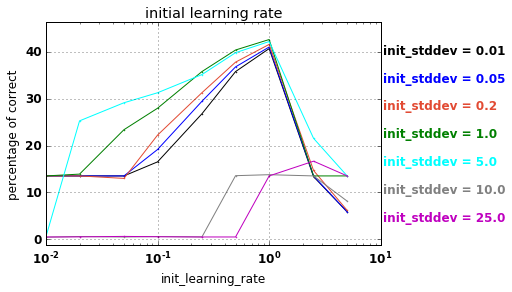

In [26]:
plot_options = {'x': 'log'}
plot_data, _ = ACT_RNN_adjustment_plots.one_key_layout_data('ACT_RNN_1',
                                                             "init_learning_rate",
                                                            'init_stddev')
ACT_RNN_adjustment_plots.save_layout(plot_data[0],
                    'initial learning rate',
                    ['adjustment'],
                    'init_learning_rate_nn128;ns5000;hl500;dc0.9',
                     plot_options=plot_options)
ACT_RNN_adjustment_plots.draw(plot_data[0], 'initial learning rate', plot_options=plot_options)

In [35]:

num_unrollings_value = 20
indent_values = [.5, .25, .1, .05, .02, .01, .005, .002, .001]
time_penalty_values = [0.0000003, 0.0000001, 0.]
results_GL = list()

for indent_value in indent_values:
    print(' '*4, "indent: ", indent_value)
    for time_penalty_value in time_penalty_values:
        print(' '*2, "time penalty: ", time_penalty_value)
        model = ACT_RNN(64,
                                                vocabulary,
                                                characters_positions_in_vocabulary,
                                             num_unrollings_value,            #number of memory layers
                                             [128],
                    5,
                    indent_value,
                    time_penalty_value,
            train_text,
            valid_text_2)
        model.simple_run(100,
                                       'ACT_RNN/variables/nn128_dth_5_nu20_bs64_ilr10_hl500_ns20000/idt%s_tp%s' %
                                     (indent_value, time_penalty_value),
                                       20000,
                                       4000,
                                       5000,        #learning has a chance to be stopped after every block of steps
                                       40,
                                       0.9,
                                       3,
                                     fixed_num_steps=True)
        results_GL.extend(model._results)
        model.destroy()
        del model
        gc.collect()

     indent:  0.5
   time penalty:  3e-07
Number of steps = 20000     Percentage = 46.37%     Time = 2366s     Learning rate = 0.0148
   time penalty:  1e-07
Number of steps = 20000     Percentage = 46.50%     Time = 2382s     Learning rate = 0.0148
   time penalty:  0.0
Number of steps = 20000     Percentage = 48.29%     Time = 2360s     Learning rate = 0.0148
     indent:  0.25
   time penalty:  3e-07
Number of steps = 20000     Percentage = 48.68%     Time = 2290s     Learning rate = 0.0148
   time penalty:  1e-07
Number of steps = 20000     Percentage = 48.75%     Time = 2238s     Learning rate = 0.0148
   time penalty:  0.0
Number of steps = 20000     Percentage = 48.81%     Time = 1622s     Learning rate = 0.0148
     indent:  0.1
   time penalty:  3e-07
Number of steps = 20000     Percentage = 48.95%     Time = 2401s     Learning rate = 0.0148
   time penalty:  1e-07
Number of steps = 20000     Percentage = 48.81%     Time = 2370s     Learning rate = 0.0148
   time penalty:  0.0

In [32]:
folder_name = 'ACT_RNN'
file_name = 'ACT_RNN_ns_20000_hl_500_dc_0.9_nu_20_idt0.001_0.5_tp0.1_0.0001.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling ACT_RNN/ACT_RNN_ns_20000_hl_500_dc_0.9_nu_20_idt0.001_0.5_tp0.1_0.0001.pickle.


In [34]:
folder_name = 'ACT_RNN'
file_name = 'ACT_RNN_ns_20000_hl_500_dc_0.9_nu_20_idt0.001_0.5_tp3e-5_1e-6.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling ACT_RNN/ACT_RNN_ns_20000_hl_500_dc_0.9_nu_20_idt0.001_0.5_tp3e-5_1e-6.pickle.


In [36]:
folder_name = 'ACT_RNN'
file_name = 'ACT_RNN_ns_20000_hl_500_dc_0.9_nu_20_idt0.001_0.5_tp3e-7_0.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling ACT_RNN/ACT_RNN_ns_20000_hl_500_dc_0.9_nu_20_idt0.001_0.5_tp3e-7_0.pickle.


In [11]:
folder_name = 'ACT_RNN'
pickle_file = 'ACT_RNN_ns_20000_hl_500_dc_0.9_nu_20_idt0.001_0.5_tp0.1_0.0001.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL = save['results_GL']
  del save  # hint to help gc free up memory

In [12]:
folder_name = 'ACT_RNN'
pickle_file = 'ACT_RNN_ns_20000_hl_500_dc_0.9_nu_20_idt0.001_0.5_tp3e-5_1e-6.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL.extend(save['results_GL'])
  del save  # hint to help gc free up memory

In [13]:
folder_name = 'ACT_RNN'
pickle_file = 'ACT_RNN_ns_20000_hl_500_dc_0.9_nu_20_idt0.001_0.5_tp3e-7_0.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL.extend(save['results_GL'])
  del save  # hint to help gc free up memory

In [14]:
folder_name = 'ACT_RNN'
file_name = 'ACT_RNN_all.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling ACT_RNN/ACT_RNN_all.pickle.


In [15]:
from plot_module import ComparePlots

ACT_RNN_plots = ComparePlots('ACT_RNN')
ACT_RNN_plots.add_network(results_GL, model._indices)

['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


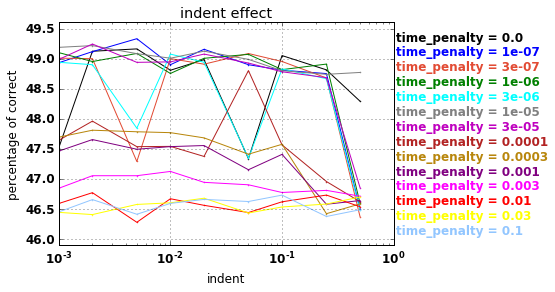

In [16]:
plot_options = {'x': 'log'}
plot_data, _ = ACT_RNN_plots.one_key_layout_data('ACT_RNN_1',
                                         'indent',
                                                       'time_penalty')
ACT_RNN_plots.save_layout(plot_data[0],
                    'indent effect',
                    ['plots'],
                    'idt_eff_nl1;nn128;ns20000;hl500;dc0.9',
                              plot_options=plot_options)
ACT_RNN_plots.draw(plot_data[0], 'indent effect', plot_options=plot_options)

['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']


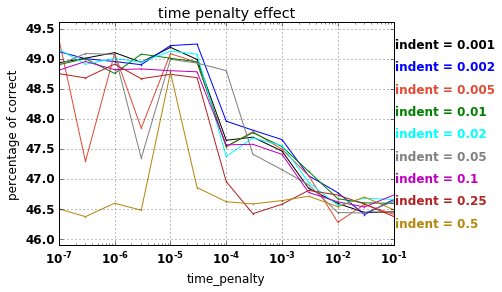

In [17]:
plot_options = {'x': 'log'}
plot_data, _ = ACT_RNN_plots.one_key_layout_data('ACT_RNN_1',
                                         'time_penalty',
                                                       'indent')
ACT_RNN_plots.save_layout(plot_data[0],
                    'time penalty effect',
                    ['plots'],
                    'tp_eff_nl1;nn128;ns20000;hl500;dc0.9',
                              plot_options=plot_options)
ACT_RNN_plots.draw(plot_data[0], 'time penalty effect', plot_options=plot_options)

In [27]:
short_results = dict()
for result in results_GL:
    if result['metadata'][model._indices['time_penalty']] not in short_results.keys():
        short_results[result['metadata'][model._indices['time_penalty']]] = dict()
        short_results[result['metadata'][model._indices['time_penalty']]][result['metadata'][model._indices['indent']]] = result['data']['train']['percentage'][-1]
    elif result['metadata'][model._indices['indent']] not in short_results[result['metadata'][model._indices['time_penalty']]].keys():
        short_results[result['metadata'][model._indices['time_penalty']]][result['metadata'][model._indices['indent']]] = result['data']['train']['percentage'][-1]
    else:
        print('Error! Skipping')
        print(result)

In [30]:
print(short_results.keys())

[0.0, 0.0003, 1e-06, 1e-05, 3e-06, 0.1, 1e-07, 0.001, 0.0001, 0.03, 3e-07, 0.003, 3e-05, 0.01]


In [35]:

num_unrollings_value = 20
indent_values = [.5, .25, .1, .05, .02, .01, .005, .002, .001]
time_penalty_values = [0.0000003,
                       0.0000001,
                       0.,
                       .000001,
                       .000003,
                       .00001,
                       .00003,
                       .0001,
                       .0003,
                       .001,
                       .003,
                       .01,
                       .03,
                       .1]
results_GL = list()

for indent_value in indent_values:
    print(' '*4, "indent: ", indent_value)
    for time_penalty_value in time_penalty_values:
        print(' '*2, "time penalty: ", time_penalty_value)
        model = ACT_RNN(64,
                                                vocabulary,
                                                characters_positions_in_vocabulary,
                                             num_unrollings_value,            #number of memory layers
                                             [128],
                    5,
                    indent_value,
                    time_penalty_value,
            train_text,
            valid_text)
        text_list, iter_list = model.run_for_analitics(model.get_iterations,
                                                        'ACT_RNN/variables/nn128_dth_5_nu20_bs64_ilr10_hl500_ns20000/idt%s_tp%s' % (indent_value, time_penalty_value),
                                                        [300, 75, None])

        structure_vocabulary_plots(text_list,
                                   iter_list,
                                   'iterations (indent: %s; time penalty: %s; result: %.2f%%)' % (indent_value, time_penalty_value, short_results[time_penalty_value][indent_value]),
                                   'iterations',
                                   ['ACT_RNN', 'iterations', 'vocabulary_plots'],
                                   'ns20k_idt%s_tp%s' % (indent_value, time_penalty_value),
                                   ylims = [1., 5.],
                                   ylims_fixed=True,
                                   show=False)
        for i in range(50):
            text_plot(text_list[i],
                      iter_list[i],
                      'iterations',
                      'iterations (indent: %s; time penalty: %s; result: %.2f%%)' % (indent_value, time_penalty_value, short_results[time_penalty_value][indent_value]),
                      ['ACT_RNN', 'text_plots', 'ns20k_nn128', 'idt%s_tp%s' % (indent_value, time_penalty_value)],
                      'ns20k_idt%s_tp%s#%s' % (indent_value, time_penalty_value, i),
                      ylims=[1., 5.],
                      show=False)
        model.destroy()
        del model
        gc.collect()

     indent:  0.5
   time penalty:  3e-07
   time penalty:  1e-07
   time penalty:  0.0
   time penalty:  1e-06
   time penalty:  3e-06
   time penalty:  1e-05
   time penalty:  3e-05
   time penalty:  0.0001
   time penalty:  0.0003
   time penalty:  0.001
   time penalty:  0.003
   time penalty:  0.01
   time penalty:  0.03
   time penalty:  0.1
     indent:  0.25
   time penalty:  3e-07
   time penalty:  1e-07
   time penalty:  0.0
   time penalty:  1e-06
   time penalty:  3e-06
   time penalty:  1e-05
   time penalty:  3e-05
   time penalty:  0.0001
   time penalty:  0.0003
   time penalty:  0.001
   time penalty:  0.003
   time penalty:  0.01
   time penalty:  0.03
   time penalty:  0.1
     indent:  0.1
   time penalty:  3e-07
   time penalty:  1e-07
   time penalty:  0.0
   time penalty:  1e-06
   time penalty:  3e-06
   time penalty:  1e-05
   time penalty:  3e-05
   time penalty:  0.0001
   time penalty:  0.0003
   time penalty:  0.001
   time penalty:  0.003
   time penalty: 